# (15) PCA, NMF, Raw

**Motivation**: <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-MTMST/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-MTMST/figs')
tmp_dir = os.path.join(git_dir, 'jb-MTMST/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_MTMST'))
from vae.train_vae import TrainerVAE, ConfigTrainVAE
from vae.vae2d import VAE, ConfigVAE
from figures.fighelper import *
from analysis.glm import *


# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
from base.dataset import ROFLDS
from analysis.linear import compute_dci

label2latex = {
    'fix_x': r'$F_x$',
    'fix_y': r'$F_y$',
    'slf_v_x': r'$V_{self, x}$',
    'slf_v_y': r'$V_{self, y}$',
    'slf_v_z': r'$V_{self, z}$',
    'obj0_x': r'$X_{obj}$',
    'obj0_y': r'$Y_{obj}$',
    'obj0_z': r'$Z_{obj}$',
    'obj0_v_x': r'$V_{obj, x}$',
    'obj0_v_y': r'$V_{obj, y}$',
    'obj0_v_z': r'$V_{obj, z}$',
}
pal_model, pal_cat = get_palette()


def compute_importances(
    x: np.ndarray,
    y: np.ndarray,
    x_tst: np.ndarray,
    y_tst: np.ndarray,
    n_repeats: int = 5,
    random_state: int = 0,
    verbose: bool = True, ):

    assert x.ndim == y.ndim == 2
    assert x.shape[1] == x_tst.shape[1]
    assert y.shape[1] == y_tst.shape[1]
    
    shape = (y.shape[1], x.shape[1])
    importances_mu = np.zeros(shape)
    importances_sd = np.zeros(shape)

    for i in tqdm(range(shape[0]), leave=not verbose):
        _lr = sk_linear.LinearRegression().fit(x, g[:, i])
        result = sk_inspect.permutation_importance(
            estimator=_lr,
            X=x_tst,
            y=y_tst[:, i],
            n_repeats=n_repeats,
            random_state=random_state,
        )
        importances_mu[i] = result.importances_mean
        importances_sd[i] = result.importances_std
        
    return importances_mu, importances_sd

## load dataset

In [3]:
category = 'fixate1'
sim_path = f"/home/hadi/Documents/MTMST/data/{category}_dim-17_n-750k"
ds_trn = ROFLDS(sim_path, 'trn')
ds_vld = ROFLDS(sim_path, 'vld')
ds_tst = ROFLDS(sim_path, 'tst')
assert ds_trn.f + ds_trn.f_aux \
    == ds_vld.f + ds_vld.f_aux \
    == ds_tst.f + ds_tst.f_aux

# select main ground-truth variables
select_i, select_lbl = zip(*[
    (i, lbl) for i, lbl in
    enumerate(ds_trn.f + ds_trn.f_aux)
    if lbl in label2latex
])
select_i = np.array(select_i)
select_lbl = list(select_lbl)

g = np.concatenate([ds_vld.g, ds_vld.g_aux], axis=1)[:, select_i]
g_tst = np.concatenate([ds_tst.g, ds_tst.g_aux], axis=1)[:, select_i]

## PCA

In [4]:
nf = 420

pca = sk_decomp.PCA(
    n_components=nf,
    svd_solver='full',
).fit(flatten_stim(ds_trn.x))

x = pca.transform(flatten_stim(ds_vld.x))
x_tst = pca.transform(flatten_stim(ds_tst.x))

lr = sk_linear.LinearRegression().fit(x, g)
r2 = sk_metric.r2_score(
    y_true=g_tst,
    y_pred=lr.predict(x_tst),
    multioutput='raw_values',
)

# compute importances matrix
importances_mu, importances_sd = compute_importances(
    x=x,
    y=g,
    x_tst=x_tst,
    y_tst=g_tst,
)

w = np.maximum(0, importances_mu)
rho = w.sum(0) / w.sum()
d, c = compute_dci(w)

In [5]:
pca_results = {
    'importances_mu': importances_mu,
    'importances_sd': importances_sd,
    'r2': r2,
    'd': d,
    'c': c,
    'i': r2.mean(),
    'dci': np.mean([d, c, r2.mean()]),
}

In [17]:
save_obj(
    obj=pca_results,
    file_name='pca_results',
    save_dir=tmp_dir,
    mode='npy'
);

[PROGRESS] 'pca_results.npy' saved at
/home/hadi/Dropbox/git/jb-MTMST/tmp

In [6]:
pca_results

{'importances_mu': array([[ 1.90665043e-05, -5.08879864e-05,  6.75894468e-06, ...,
         -8.86629204e-05,  1.75110730e-05, -4.92245118e-06],
        [ 1.14071565e-05,  2.67893622e-05, -1.30911361e-04, ...,
         -1.66929975e-05,  5.38865374e-06,  8.30637370e-06],
        [-6.72876909e-05,  5.24298146e-01,  4.36874748e-01, ...,
          9.45328083e-05,  7.78645143e-06,  3.55981454e-07],
        ...,
        [-6.21337356e-06,  1.87067132e-02,  1.63329484e-02, ...,
          5.69691308e-05,  1.24007402e-05, -2.97119740e-05],
        [-2.53641564e-06,  1.53715932e-02,  1.83846102e-02, ...,
          2.18179246e-06,  1.53779317e-05,  1.90729132e-05],
        [ 5.51510979e-03,  1.32557767e-05,  8.17136115e-05, ...,
         -1.40618693e-04, -5.69414041e-07, -6.98378040e-06]]),
 'importances_sd': array([[2.00596595e-05, 2.56592229e-05, 1.03571476e-05, ...,
         4.05966938e-05, 2.72717187e-06, 8.36564671e-06],
        [7.67590124e-06, 1.09653119e-05, 5.06269734e-05, ...,
         1.

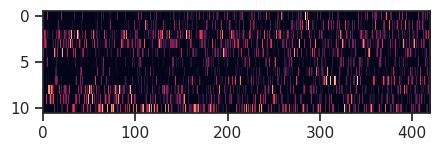

In [14]:
plt.imshow(w / w.sum(0, keepdims=True), aspect=10)

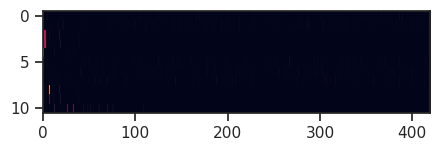

In [15]:
plt.imshow(w / w.sum(1, keepdims=True), aspect=10)

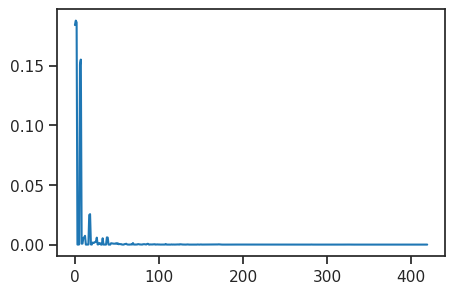

In [16]:
plt.plot(rho)

## Raw

In [4]:
df_i_r2_raw = []
df_dci_raw = collections.defaultdict(list)

# R^2
lr = sk_linear.LinearRegression().fit(
    flatten_stim(ds_vld.x), g)
r2 = sk_metric.r2_score(
    y_true=g_tst,
    y_pred=lr.predict(flatten_stim(ds_tst.x)),
    multioutput='raw_values',
)
nf = flatten_stim(ds_vld.x).shape[1]
df_i_r2_raw.append({
    'model': ['RAW'] * len(r2),
    'category': [category] * len(r2),
    'beta': ['ae'] * len(r2),
    'nf': [nf] * len(r2),
    'f': select_lbl,
    'r2': r2,
})
r2 = np.nanmean(r2)
df_dci_raw['i'].append(r2)

# compute importances matrix
importances_mu, importances_sd = compute_importances(
    x=flatten_stim(ds_vld.x),
    y=g,
    x_tst=flatten_stim(ds_tst.x),
    y_tst=g,
)

# DC
w = np.maximum(0, importances_mu)
rho = w.sum(0) / w.sum()
d, c = compute_dci(w)

df_dci_raw['model'].append('RAW')
df_dci_raw['category'].append(category)
df_dci_raw['beta'].append('ae')
df_dci_raw['nf'].append(nf)
df_dci_raw['d'].append(d)
df_dci_raw['c'].append(c)
df_dci_raw['dci'].append(np.mean([d, c, r2]))
df_dci_raw['rho_ent'].append(entropy_normalized(rho))

df_dci_raw = pd.DataFrame(df_dci_raw)
df_i_r2_raw = pd.DataFrame(merge_dicts(df_i_r2_raw))

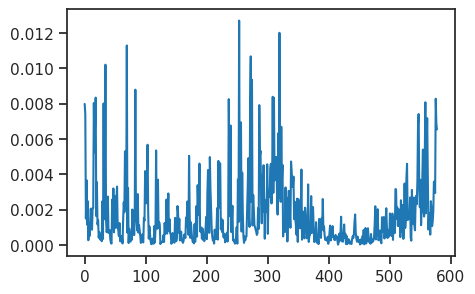

In [7]:
plt.plot(rho)

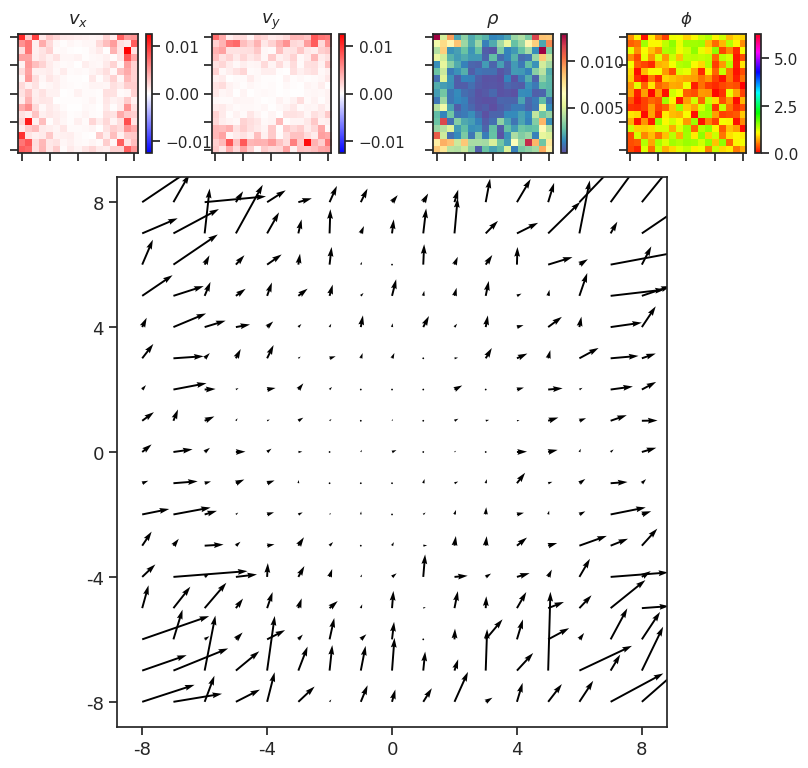

(<Figure size 1000x900 with 9 Axes>,
 array([<Axes: title={'center': '$v_x$'}>,
        <Axes: title={'center': '$v_y$'}>,
        <Axes: title={'center': '$\\rho$'}>,
        <Axes: title={'center': '$\\phi$'}>, <Axes: >], dtype=object))

In [8]:
show_opticflow_full(rho.reshape(2, 17, 17));

In [9]:
df_dci

,i,d,c,dci,rho_ent
0,23.458948,0.471353,0.203273,0.303072,0.919586


In [10]:
df_i_r2

,model,category,beta,nf,f,r2
0,RAW,fixate1,ae,578,fix_x,-0.862515
1,RAW,fixate1,ae,578,fix_y,-0.811638
2,RAW,fixate1,ae,578,slf_v_x,55.991183
3,RAW,fixate1,ae,578,slf_v_y,56.498482
4,RAW,fixate1,ae,578,slf_v_z,51.973174
5,RAW,fixate1,ae,578,obj0_x,-0.363107
6,RAW,fixate1,ae,578,obj0_y,-0.361998
7,RAW,fixate1,ae,578,obj0_z,-0.940251
8,RAW,fixate1,ae,578,obj0_v_x,46.821294
9,RAW,fixate1,ae,578,obj0_v_y,47.098742


In [4]:
lr = sk_linear.LinearRegression().fit(
    flatten_stim(ds_vld.x), g)
r2 = sk_metric.r2_score(
    y_true=g_tst,
    y_pred=lr.predict(flatten_stim(ds_tst.x)),
    multioutput='raw_values',
)

In [5]:
r2

array([-0.00862515, -0.00811638,  0.55991183,  0.56498482,  0.51973174,
       -0.00363107, -0.00361998, -0.00940251,  0.46821294,  0.47098742,
        0.03005062])

In [6]:
r2.mean()

0.2345894806866853

## Decomposition

In [8]:
nf = 420

## PCA

In [16]:
r2, np.mean(r2)

(array([-0.00650818, -0.00527431,  0.55987699,  0.56495145,  0.52101902,
        -0.00273586, -0.00268859, -0.00718614,  0.46998505,  0.47200851,
         0.03257805]),
 0.23600236432270313)

## NMF

In [7]:
nmf = sk_decomp.NMF(
    init='nndsvd',
    random_state=0,
).fit(flatten_stim(sp_lin.norm(ds_trn.x, axis=1)))

/home/hadi/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [8]:
x = nmf.transform(flatten_stim(sp_lin.norm(ds_vld.x, axis=1)))
x_tst = nmf.transform(flatten_stim(sp_lin.norm(ds_tst.x, axis=1)))

KeyboardInterrupt: 

In [ ]:
lr = sk_linear.LinearRegression().fit(x, g)
r2 = sk_metric.r2_score(
    y_true=g_tst,
    y_pred=lr.predict(x_tst),
    multioutput='raw_values',
)

In [ ]:
r2, np.mean(r2)

In [11]:
nmf.components_.shape

(289, 289)

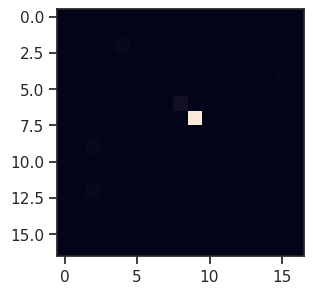

In [32]:
plt.imshow(nmf.components_[20].reshape(17, 17))

## ICA

In [34]:
nf = 420

In [36]:
ica = sk_decomp.FastICA(
    n_components=nf,
    random_state=0,
).fit(flatten_stim(ds_trn.x))

In [37]:
x = ica.transform(flatten_stim(ds_vld.x))
x_tst = ica.transform(flatten_stim(ds_tst.x))

In [42]:
lr = sk_linear.LinearRegression().fit(x, g)
r2 = sk_metric.r2_score(
    y_true=g_tst,
    y_pred=lr.predict(x_tst),
    multioutput='raw_values',
)

In [43]:
r2, np.mean(r2)

(array([-0.00651156, -0.00528126,  0.55988125,  0.56495219,  0.52102307,
        -0.00273901, -0.00268856, -0.00719153,  0.46998437,  0.47201137,
         0.03254154]),
 0.23599835097351615)